In [1]:
from FlowControl import *
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series

<h1>Linear Regression model</h1>

<h3>Testing data generator</h3>

In [2]:
data_set_generator = Generate_Synth_Data_LR(4)
data_set = data_set_generator.fetch_data()

print(f"vector w: {data_set_generator.get_w()}")

vector w: [85.85979199 69.73680291  9.41773479 97.56223516 76.1139702 ]


In [3]:
data_set["features"][:5]

,x0,x1,x2,x3
0,-0.015361,5.505195,0.729154,-3.420061
1,-0.663984,-1.606308,0.205510,-0.476918
2,1.035905,6.251506,-2.924334,2.438075
3,1.058950,-2.477122,-4.949227,2.737297
4,0.524139,1.268894,1.510258,-2.836239


In [4]:
print(data_set["target"][:5])

y    [11.868802091876844, 77.1356836248911, 485.721...
dtype: object


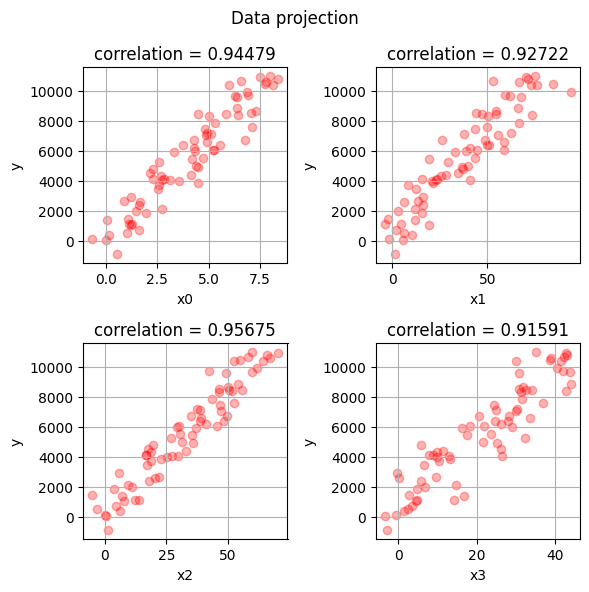

In [5]:
vis = Visualize_Linear_Data(data_set)

fig = plt.figure(figsize = (6,6))
axs = vis.plot_raw_points(fig)

fig.suptitle("Data projection")
plt.tight_layout()
plt.show()

Dataset should be splitted into two parts: train set - which is used for training model, and test set - which is used for evaluataing the accuracy of fitted data

In [6]:
X_data = data_set["features"].to_numpy()
print("X data shape: ",X_data.shape)

y_data = data_set["target"]["y"]
print("y data shape: ",y_data.shape)

X data shape:  (70, 4)
y data shape:  (70,)


In [7]:
def train_test_split_2(X_data,y_data,size = 0.7):
    n,_ = X_data.shape
    inds = np.random.choice(n,int(size * n))
    inds_prime = [i for i in range(n) if (i not in inds)]
    return X_data[inds],y_data[inds],X_data[inds_prime],y_data[inds_prime]

In [8]:
X_train,y_train,X_test,y_test = train_test_split_2(X_data,y_data)

In [9]:
print("X train shape: ",X_train.shape)
print("y train shape: ",y_train.shape)
print("X test shape: ",X_test.shape)
print("y test shape: ",y_test.shape)

X train shape:  (49, 4)
y train shape:  (49,)
X test shape:  (38, 4)
y test shape:  (38,)


<h2>Linear Model</h2>

<h2>Basic set-up</h2>

Linear regression model is based on the assumption that $y$ depends on $\vec{x}$ according to certain linear function. If we are given particular data set: $\{\hat{y}^{(i)},\vec{x}^{(i)}\}_{i=1}^{n}$
$$
\hat{y}^{(i)} = \vec{\omega}\cdot\vec{x}^{(i)} + \varepsilon^{(i)}
$$
where $\varepsilon^{(i)}$ is the error. We also assume that $\varepsilon^{(i)}$ is normally distributed:
$$
p(\varepsilon^{(i)}) = \frac{1}{\sqrt{2\pi\sigma}}\exp{(-\frac{\varepsilon^{(i)}}{2\sigma^{2}})}
$$
On the basis of our model assumptions one can infer that $p(\varepsilon^{(i)}) = p(\hat{y}^{(i)}|\vec{x}^{(i)}; \vec{\omega})$ so that the probability for obtaining $\hat{y}^{(i)}$ given $\vec{x}^{(i)}$ is maximal, if  $\vec{\omega}$ is chosen specifically to fit $\hat{y}^{(i)} = \vec{\omega}\cdot \vec{x}^{(i)}$

For the total dataset we have to take into account also other training points: 
$$
P(\hat{y} | X; \vec{\omega}) = \prod_{i=1}^{n}p(\hat{y}^{(i)}|\vec{x}^{(i)}; \vec{\omega})
$$
where the equality is related with the fact that data points are independent of each other.

Here, we vectorized data:
$$
\hat{y} = \left[
\begin{array}{ccc}
\hat{y}^{(1)} &
\ldots &
\hat{y}^{(n)} 
\end{array}
\right]^{T} \in \mathbb{R}^{n}
$$

$$
X = \left[
\begin{array}{ccccc}
x^{(1)}_{1} & \dots & x^{(1)}_{d} &|& 1 \\
\ldots & \ldots & \ldots &|& \ldots \\
x^{(n)}_{1} & \dots & x^{(n)}_{d} &|& 1 \\
\end{array}
\right] = 
\left[
\begin{array}{ccc}
- & (\vec{x}^{(1)})^{T} & - \\
- & \ldots & -  \\
- & (\vec{x}^{(n)})^{T} & - \\
\end{array}
\right]
\in \mathbb{R}^{n\times d+1}
$$

$$
\vec{\omega} = \left[
\begin{array}{cccc}
\omega_{1} &
\ldots &
\omega_{d} &
\omega_{d + 1}
\end{array}
\right]^{T} \in \mathbb{R}^{d+1}
$$

<h2>Cost function</h2>

Maximizing Probability $P(\hat{y} | X; \vec{\omega}) $ is equivalent to minimizing negative log-likelykood:
$$
\hat{\mathcal{L}}(\vec{\omega}) = -\log{P(\hat{y} | X; \vec{\omega})} = -\log{\prod_{i=1}^{n}p(\hat{y}^{(i)}|\vec{x}^{(i)}; \vec{\omega})} = -\sum_{i= 1}^{n}\log{p(\hat{y}^{(i)}|\vec{x}^{(i)};\vec{\omega})}
$$
$$
\hat{\mathcal{L}}(\vec{\omega}) = \sum_{i= 1}^{n}\big[ \frac{1}{2}\log{2\pi \sigma} + \frac{1}{2\sigma^{2}}(\hat{y}^{(i)} - \vec{\omega}\cdot \vec{x}^{(i)})^{2} \big]
$$

It is clear that we can rescale the function and also gauge its zero-point. Therefore minimizing log-likelyhood can be also transformed to the problem of minmizing **cost function**:
$$
\mathcal{L}(\vec{\omega}) = \frac{1}{2n}\sum_{i=1}^{n}(\hat{y}^{(i)} - \vec{\omega}\cdot \vec{x}^{(i)})^{2} = \frac{1}{2n}(\hat{y} - X\vec{\omega})^{T}(\hat{y} - X\vec{\omega})
$$
Gradient of the $\mathcal{L}(\vec{\omega})$ can be computed as:
$$
\vec{\nabla}_{\vec{\omega}}\mathcal{L}(\vec{\omega}) = -\frac{1}{n}\sum_{i=1}^{n}(\hat{y}^{(i)} - \vec{\omega}\cdot \vec{x}^{(i)})\vec{x}^{(i)} = -\frac{1}{n}X^{T}(\hat{y} - X\vec{\omega})
$$

<h2>Batch Gradient Descent algorithm</h2>

Algorithm for minimizing Cost function: 
1. Initialize  vector $\vec{\omega}_{0}$ randomly
2. For $t$ in $1:steps$ update components of $\vec{\omega}$ according to:
$$
\vec{\omega}_{t+1} = \vec{\omega}_{t} + \alpha \frac{1}{|\mathcal{B}_{t}|}\sum_{i \in \mathcal{B}_{t}} (\hat{y}^{(i)} - \vec{\omega}\cdot \vec{x}^{(i)})\vec{x}^{(i)}
$$

$\mathcal{B}_{t}$ is a set of indices from the set $\mathcal{I} = \{1,\ldots ,n\}$. These indices are randomly chosen in each step of learning algorithm. We can distinguish 3 different cases:
1. $|\mathcal{B}_{t}| = 1$ - **Stochastic Gradient Descent**
2. $1 < |\mathcal{B}_{t}| < n$ - **Mini-batch Gradient Descent**
3. $|\mathcal{B}_{t}| = n$ - **Deterministic Gradient Descent**

$\alpha$ is the so-called **learning rate** and it determine how fast we make another step.

<h2>Implementation from scratch</h2>

In [10]:
class LinearRegression_:
    def __init__(self,alpha = 0.01,steps = 1000):
        self.alpha = alpha
        self.steps = steps

    def fit(self,X,y,batch_size = 1,seed = 42):
        #default setting : Stochastic gradient descent
        raise NotImplementedError

    def batch_grad(self,X,y,B):
        raise NotImplementedError
    
    def Cost_function(self,X,y):
        raise NotImplementedError
    
    def PreProcessing(self,X,y):
        raise NotImplementedError

In [11]:
@add_to_class(LinearRegression_)
def fit(self,X,y,batch_size = 1,seed = 42,collect_data = False,scale_features = False):
    assert isinstance(X,np.ndarray) , "Invalid input datatype for X"
    assert isinstance(y,np.ndarray) , "Invalid input datatype for y"

    if len(X.shape) == 1:
        n = X.shape
        d = 1
    else:
        n,d = X.shape

    X_prime,y_prime,means_x,stds_x,means_y,stds_y = self.PreProcessing(X,y,scale_features)
    X_bias = np.hstack((X_prime,np.ones(n).reshape(-1,1)))
    rng = np.random.default_rng(seed)
    self.w_ = rng.normal(loc = 0. , scale = 0.1,size = d+1)
    L_data = []
    w_data = []

    for _ in range(self.steps):
        if collect_data:
            L_data.append(self.Cost_function(X_bias,y))
            w_data.append(self.w_)
        B = np.random.choice(n,size = batch_size)
        self.w_ += self.alpha / len(B) * self.batch_grad(X_bias,y_prime,B)
        
    self.rescale_features(means_x,stds_x,means_y,stds_y,scale_features)
    if collect_data:
        return self.w_,L_data,w_data
    else:
        return self.w_

@add_to_class(LinearRegression_)
def rescale_features(self,means_x,stds_x,means_y,stds_y,scale_features = True):
    if scale_features:
        self.w_[-1] = stds_y*self.w_[-1]+means_y - sum(means_x * self.w_[:-1] /stds_x) * stds_y
        self.w_[:-1] = self.w_[:-1] * stds_y / stds_x
    
@add_to_class(LinearRegression_)
def PreProcessing(self,X,y,scale_features = True):
    means_x = np.mean(X,axis = 0)
    stds_x = np.std(X,axis = 0)

    means_y = np.mean(y)
    stds_y = np.std(y)
    if scale_features:
        return (X-means_x)/stds_x, (y-means_y)/stds_y, means_x,stds_x,means_y,stds_y
    else:
        return X, y, means_x,stds_x,means_y,stds_y

@add_to_class(LinearRegression_)
def batch_grad(self,X,y,B):
    return (X[B]).T @ ((y - X @ self.w_)[B])

@add_to_class(LinearRegression_)
def Cost_function(self,X,y):
    side1 = (y - X @ self.w_)
    return side1.T @ side1 / X.shape[0]

Without Scaling features:

In [12]:
model = LinearRegression_(alpha=1e-5,steps = 200000)
w_t_non_sc, L_d_non_sc , w_d_non_sc = model.fit(X_train,y_train,batch_size=5,collect_data=True,scale_features=False)

print(w_t_non_sc)

[315.3247347   52.03001944  68.11331121  -6.69075006 137.6074008 ]


Scaling features according to:
$$
x_{k}'^{(i)} := \frac{x_{k}^{(i)} - \langle x_{k}^{(i)} \rangle_{sample}}{\sigma_{x_{k}}}
$$
$$
y'^{(i)} := \frac{y^{(i)} - \langle y^{(i)} \rangle_{sample}}{\sigma_{y}}
$$

because:
$$
y'= \sum_{k=1}^{d}\omega_{k}'x_{k}' + \omega_{d+1}'
$$
$$
y-\langle y \rangle = \sigma_{y}(\sum_{k=1}^{d}\frac{\omega_{k}'}{\sigma_{x_{k}}}x_{k} - \sum_{k=1}^{d}\frac{\omega_{k}'}{\sigma_{x_{k}}}\langle x_{k} \rangle   + \omega_{d+1}') = 
$$
$$
 = \sum_{k=1}^{d}\big(\frac{\sigma_{y}}{\sigma_{x_{k}}}\omega_{k}'\big)x_{k} + \big(\sigma_{y}\omega_{d+1}' - \sigma_{y}\sum_{k=1}^{d}\frac{\langle x_{k} \rangle\omega_{k}'}{\sigma_{x_{k}}} \big) 
$$

Therefore if we've found $\vec{\omega}'$ for re-scaled features, then we can easily find our original vector components:
$$
\omega_{k} = \frac{\sigma_{y}}{\sigma_{x_{k}}}\omega_{k}' 
$$
$$
\omega_{d+1} = \sigma_{y}\omega_{d+1}' + \langle y \rangle - \sigma_{y}\sum_{k=1}^{d}\frac{\langle x_{k} \rangle\omega_{k}'}{\sigma_{x_{k}}} 
$$


In [13]:
model = LinearRegression_(alpha=1e-2,steps = 200000)
w_t, L_d , w_d = model.fit(X_train,y_train,batch_size=X_train.shape[0],collect_data=True,scale_features=True)

print("output w vector: ",w_t)

output w vector:  [388.08382627  49.70715811  57.07356408  -9.34277155 402.80126385]


In [14]:
_, L_d0 , w_d0 = model.fit(X_train,y_train,batch_size=1,collect_data=True,scale_features=True)
_, L_d1 , w_d1 = model.fit(X_train,y_train,batch_size=5,collect_data=True,scale_features=True)
_, L_d2 , w_d2 = model.fit(X_train,y_train,batch_size=X_train.shape[0],collect_data=True,scale_features=True)

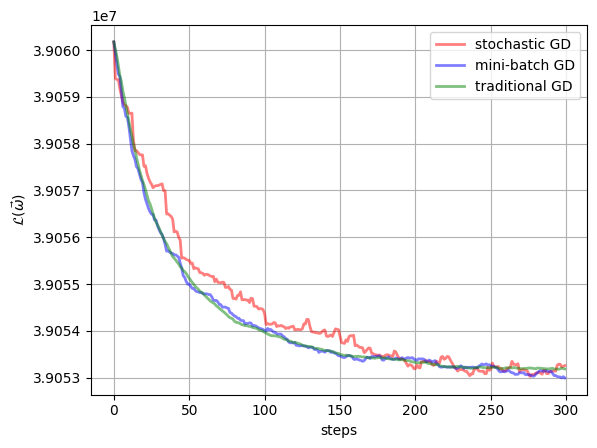

In [15]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(L_d0[:300],lw = 2,color = "red",alpha = 0.5,label = "stochastic GD")
ax.plot(L_d1[:300],lw = 2,color = "blue",alpha = 0.5,label = "mini-batch GD")
ax.plot(L_d2[:300],lw = 2,color = "green",alpha = 0.5,label = "traditional GD")
ax.grid(True)
ax.set_xlabel("steps")
ax.set_ylabel(r"$\mathcal{L}(\vec{\omega})$")
ax.legend()
plt.show()

<h1>Scikit learn implementation</h1>

Simple linear regression

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

print(f"w vector for fitting: {model.coef_}, {model.intercept_}")
print(f"regression score {model.score(X_test,y_test)}")

w vector for fitting: [390.58494377  49.47282966  57.3406578   -8.64213207], 387.9164960532016
regression score 0.9203330455951378


Stochastic GD:

In [17]:
from sklearn.linear_model import SGDRegressor

modelSGD = SGDRegressor(loss="squared_error",shuffle=True)
modelSGD.fit(X_train,y_train)

print(f"w vector for fitting: {modelSGD.coef_}, {modelSGD.intercept_}")
print(f"regression score {modelSGD.score(X_test,y_test)}")


w vector for fitting: [ 4.46999541e+10 -8.31881169e+10 -1.15019418e+11  1.67112331e+09], [-6.82982349e+10]
regression score -5.423071386614318e+18


SGD is not working in this case

Ridge Regression

In [18]:
from sklearn.linear_model import Ridge

modelRidge = Ridge()
modelRidge.fit(X_train,y_train)

print(f"w vector for fitting: {modelRidge.coef_}, {modelRidge.intercept_}")
print(f"regression score {modelRidge.score(X_test,y_test)}")

w vector for fitting: [381.51342377  49.64101239  58.04404814  -8.30545917], 387.567875761707
regression score 0.9204174624197712


In [19]:
from sklearn.linear_model import Lasso

modelLasso = Lasso()
modelLasso.fit(X_train,y_train)

print(f"w vector for fitting: {modelLasso.coef_}, {modelLasso.intercept_}")
print(f"regression score {modelLasso.score(X_test,y_test)}")

w vector for fitting: [389.56513136  49.49131051  57.39076139  -8.56042983], 387.94230772941773
regression score 0.9203575254288464
